The object of this section is to calculate the theoretical maximum yields for chosen product for suitable carbon sources. Therefore, we should first see which different carbon sources are avialable:

In [2]:
# Libraries to be imported:
from cobra.io import read_sbml_model, write_sbml_model # To read the model and save new newly generated model
from cobra import Reaction, Metabolite # To creat new reactions and metabolites
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Define the model based on the dataset in iY0844 with the added reactions:
iY0844_model = read_sbml_model("data/iYO844_modified.xml")

In [4]:
# Simulate base medium in the model:
iY0844_model.medium

{'EX_fe3_e': 999999.0,
 'EX_glc__D_e': 1.7,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}

First, we find all carbon exchange reactions in our model, and from this we establish a baseline to use for later reference:

In [5]:
# Create empty lists to store the...:
carbon = []
carbon_names = []

# Create a loop where we find all reactions that contains carbon:
for reaction in iY0844_model.exchanges:
    for metabolite in reaction.reactants:
        if "C" in metabolite.elements:
            carbon.append(reaction.id)
            carbon_names.append(reaction.name) 
            
# Make temporary changes in the model:
with iY0844_model:
    max_base_growth = iY0844_model.slim_optimize()
    iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1
    max_base_production = iY0844_model.slim_optimize()


Now, we create a loop going through every carbon source in our model, and see how well it produces dihydroartemisinic acid. The ID's for the different carbon sources are found in BIGG by filtering for B. subtilis. 

In [12]:
 # Define lists we will be using:
max_growth = []
max_production = []
medium=iY0844_model.medium


In [13]:
# Create loop for temporary changes in our model:
with iY0844_model:
    for reaction in carbon:
        medium['EX_glc__D_e'] = 0 # glucose in the medium
        medium[reaction]=1
        iY0844_model.medium = medium
        with iY0844_model:
            max_growth.append(iY0844_model.slim_optimize(error_value=0.))
            iY0844_model.objective = iY0844_model.reactions.ALDH1_CYP71AV1 # production of dihydroartemisinic acid
            max_production.append(iY0844_model.slim_optimize(error_value=0.))  # Determining max production
        medium[reaction]=0        


In [14]:
# Now, we collect all of the data in a dataframe:
production = {'Carbon': carbon_names,
             'Growth': max_growth,
             'Production': max_production}
df = pd.DataFrame(production, columns = ['Carbon', 'Growth', 'Production'])
print(df)

                              Carbon    Growth  Production
0              Ethanolamine exchange  0.000000    0.000000
1            Deoxy D Ribose exchange  0.037895    0.117143
2                  Cytosine exchange  0.000000    0.000000
3     5-Methylthio-D-ribose exchange  0.000000    0.000000
4                      DTMP exchange  0.046307    0.142857
..                               ...       ...         ...
191                  3'-AMP exchange  0.076673    0.234286
192                  3'-cmp exchange  0.046726    0.142857
193                  3'-GMP exchange  0.070093    0.214286
194   3 Phospho D glycerate exchange  0.005544    0.017143
195  D-fructose 6-phosphate exchange  0.058426    0.180000

[196 rows x 3 columns]


From this tabel we can see the growth and production on different carbon sources. We are only interested in carbon sources that result in growth above zero. Therefore, we remove all carbon sources where growth is equal to zero. 

In [15]:
# Create dataframe:
df= df[df['Growth'] != 0]
print(df)

                              Carbon    Growth  Production
1            Deoxy D Ribose exchange  0.037895    0.117143
4                      DTMP exchange  0.046307    0.142857
5     6 Phospho D gluconate exchange  0.051935    0.160000
7          Alpha L Arabinan exchange  0.186409    0.574286
14                 Cytidine exchange  0.045791    0.140000
..                               ...       ...         ...
191                  3'-AMP exchange  0.076673    0.234286
192                  3'-cmp exchange  0.046726    0.142857
193                  3'-GMP exchange  0.070093    0.214286
194   3 Phospho D glycerate exchange  0.005544    0.017143
195  D-fructose 6-phosphate exchange  0.058426    0.180000

[111 rows x 3 columns]


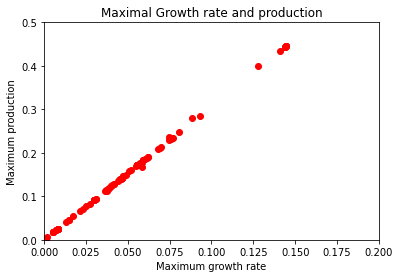

In [20]:
# We create a scatterplot of the production over growth to view the distribution
plt.scatter(df.get('Growth'), df.get('Production'),c='red')
plt.xlabel('Maximum growth rate')
plt.ylabel('Maximum production')
plt.xlim(0, 0.2)
plt.ylim(0, 0.5)
plt.title('Maximal Growth rate and production')
plt.savefig("figures/carbon_sources")
plt.show()

Now we look at the maximum growth and production obtained from glucose, which we will then compare with the growth and production obtained from other carbon sources:

In [21]:
#Original growth and production of dihydroartemisinic acid using glucose as a carbon source:
print(max_base_growth,max_base_production)

0.11796638932239784 0.36342857142856866


In [22]:
# To compare, we look at the carbon soruces resulting in the top 20 highest growth
df.sort_values(by='Growth', ascending=False).head(20)

,Carbon,Growth,Production
158,Maltotriose exchange,0.233707,0.720000
82,Raffinose exchange,0.232780,0.717143
7,Alpha L Arabinan exchange,0.186409,0.574286
157,Maltose exchange,0.144676,0.445714
109,Sucrose exchange,0.144676,0.445714
80,Cellobiose exchange,0.144676,0.445714
127,Trehalose exchange,0.144676,0.445714
176,Palatinose exchange,0.143748,0.442857
19,Dextrin exchange,0.143748,0.442857
106,Starch exchange,0.143748,0.442857


As we can see from this table, maltotiose, maltose and succrose looks promising, resulting in the 4th and 5th highest growth, respectively, while they also result in high production. We choose to continue investigation on these carbon sources, as they are the most readily available carbon sources, and will therefore not be too expensive to use in a medium.

In [25]:
# First we investigate maltotriose - we look for the ID of maltotriose:
for reaction in iY0844_model.reactions.query('Maltotriose exchange', 'name'):
    print(reaction.id)

EX_malttr_e


In [27]:
# Changing the carbon source to sucrose rather than glucose in our medium:
medium=iY0844_model.medium
medium['EX_glc__D_e'] = 0
medium["EX_malttr_e"]=1 # question to igor why 1 
iY0844_model.medium = medium
write_sbml_model(iY0844_model, "data/iYO844_modified_maltotriose.xml")
iY0844_model_maltotriose = read_sbml_model('data/iYO844_modified_maltotriose.xml')
iY0844_model_maltotriose.medium

{'EX_fe3_e': 999999.0,
 'EX_ca2_e': 999999.0,
 'EX_so4_e': 5.0,
 'EX_co2_e': 999999.0,
 'EX_h2o_e': 999999.0,
 'EX_h_e': 999999.0,
 'EX_k_e': 999999.0,
 'EX_malttr_e': 1.0,
 'EX_mg2_e': 999999.0,
 'EX_na1_e': 999999.0,
 'EX_nh4_e': 5.0,
 'EX_o2_e': 999999.0,
 'EX_pi_e': 5.0}